In [1]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 15.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:
      Successfully uninstalled scipy-1.16.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
openc

In [1]:
import numpy as np
import pandas as pd
import re
import os
import zipfile
import gensim

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Mount Google Drive to access your files
from google.colab import drive
drive.mount('/content/drive')

print("Setup Complete. Libraries imported and Google Drive mounted.")

Mounted at /content/drive
Setup Complete. Libraries imported and Google Drive mounted.


In [2]:
# Path to the .vec.zip file you have in your Google Drive
drive_path = "/content/drive/MyDrive/Depression detection dataset/wiki-news-300d-1M-subword.vec.zip"
colab_zip_path = "/content/wiki-news-300d-1M-subword.vec.zip"

print(f"Copying file from {drive_path}...")
!cp "{drive_path}" "/content/"

print(f"\nCopy complete. Unzipping {colab_zip_path}...")
!unzip "{colab_zip_path}"

print("\nFastText .vec file is now ready.")

Copying file from /content/drive/MyDrive/Depression detection dataset/wiki-news-300d-1M-subword.vec.zip...

Copy complete. Unzipping /content/wiki-news-300d-1M-subword.vec.zip...
Archive:  /content/wiki-news-300d-1M-subword.vec.zip
  inflating: wiki-news-300d-1M-subword.vec  

FastText .vec file is now ready.


In [3]:
from gensim.models import KeyedVectors

# Define the path to the unzipped .vec file
fasttext_vec_path = 'wiki-news-300d-1M-subword.vec'

print(f"Loading word vectors from {fasttext_vec_path}...")
# This will take a minute or two
ft_model = KeyedVectors.load_word2vec_format(fasttext_vec_path)

print("\nFastText vectors loaded successfully.")

Loading word vectors from wiki-news-300d-1M-subword.vec...

FastText vectors loaded successfully.


In [4]:
# Load your dataset
file_path = '/content/drive/MyDrive/Depression detection dataset/BSMDD_main.xlsx'
df = pd.read_excel(file_path)
df.dropna(subset=['text_banglish'], inplace=True)
df.reset_index(drop=True, inplace=True)

# Preprocessing function
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['cleaned_text'] = df['text_banglish'].apply(preprocess_text)
df['tokenized_text'] = df['cleaned_text'].apply(lambda x: x.split())

print("DataFrame after preprocessing and tokenization:")
print(df[['text_banglish', 'cleaned_text', 'label']].head())

DataFrame after preprocessing and tokenization:
                                       text_banglish  \
0  manasika sharirikabhabe asustha klanta puro ji...   
1  daya sathe thakuna atyanta dirgha apanake pada...   
2  janatama sathe bhula loka kharapa jibana katiy...   
3  anetibha imreji spikarera anusarana biraktikar...   
4  anetibha imreji spikarera anusarana biraktikar...   

                                        cleaned_text  label  
0  manasika sharirikabhabe asustha klanta puro ji...      1  
1  daya sathe thakuna atyanta dirgha apanake pada...      1  
2  janatama sathe bhula loka kharapa jibana katiy...      1  
3  anetibha imreji spikarera anusarana biraktikar...      1  
4  anetibha imreji spikarera anusarana biraktikar...      1  


In [5]:
# Tokenize and Pad
texts = df['cleaned_text'].tolist()
labels = df['label'].values
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
lengths = [len(s) for s in sequences]
maxlen = int(np.percentile(lengths, 95))
X = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')
y = labels
print(f"Found {len(word_index)} unique tokens. Padded to length {maxlen}.")

# Create the embedding matrix, checking for hits and misses
embedding_dim = 300
hits = 0
misses = 0
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if word in ft_model:
        embedding_matrix[i] = ft_model[word]
        hits += 1
    else:
        misses += 1

print(f"\nEmbedding Matrix Shape: {embedding_matrix.shape}")
print(f"Found {hits} words ({misses} misses) in the FastText vocabulary.")
print(f"Coverage: {100 * hits / (hits + misses):.2f}% of the vocabulary is covered.")

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nTraining data shape (X_train): {X_train.shape}")

Found 56826 unique tokens. Padded to length 192.

Embedding Matrix Shape: (56827, 300)
Found 2382 words (54444 misses) in the FastText vocabulary.
Coverage: 4.19% of the vocabulary is covered.

Training data shape (X_train): (17528, 192)


In [6]:
# --- Build the BiGRU Model ---

model = Sequential()

# 1. Embedding Layer
# We load our FastText-based embedding matrix.
# The output_dim must be 300 to match the vectors.
model.add(Embedding(input_dim=vocab_size,
                    output_dim=300, # This is 300 for our FastText model
                    weights=[embedding_matrix],
                    input_length=maxlen,
                    trainable=False))

# 2. Bidirectional GRU Layer
model.add(Bidirectional(GRU(units=64)))

# 3. Dropout for regularization
model.add(Dropout(0.3))

# 4. A standard Dense layer
model.add(Dense(32, activation='relu'))

# 5. Final Output Layer for binary classification
model.add(Dense(1, activation='sigmoid'))


# --- Compile the Model ---
from tensorflow.keras.metrics import Precision, Recall

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

# --- Print Model Summary ---
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │    17,048,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,048,100 (65.03 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 17,048,100 (65.03 MB)

In [7]:
import time

# --- Train the Model ---

print("Starting model training with FastText (.vec) embeddings...")

# Use EarlyStopping to prevent overfitting and save the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define number of epochs and batch size
epochs = 20
batch_size = 32

# Start the timer
start_time = time.time()

# Train the model
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

# Stop the timer
end_time = time.time()

# Calculate and print the training time
training_time = end_time - start_time
print(f"\nTraining finished in {training_time:.2f} seconds.")

Starting model training with FastText (.vec) embeddings...
Epoch 1/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 221s 392ms/step - accuracy: 0.5202 - loss: 0.6894 - precision: 0.5231 - recall: 0.6681 - val_accuracy: 0.6303 - val_loss: 0.6395 - val_precision: 0.7131 - val_recall: 0.4366
Epoch 2/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 217s 397ms/step - accuracy: 0.6551 - loss: 0.6219 - precision: 0.6511 - recall: 0.6860 - val_accuracy: 0.6664 - val_loss: 0.5967 - val_precision: 0.7626 - val_recall: 0.4836
Epoch 3/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 263s 399ms/step - accuracy: 0.7026 - loss: 0.5725 - precision: 0.6954 - recall: 0.7185 - val_accuracy: 0.7330 - val_loss: 0.5485 - val_precision: 0.6987 - val_recall: 0.8198
Epoch 4/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 214s 391ms/step - accuracy: 0.7229 - loss: 0.5541 - precision: 0.7132 - recall: 0.7541 - val_accuracy: 0.7211 - val_loss: 0.5616 - val_precision: 0.6972 - val_recall: 0.7824
Epoch 5/20
548/548 ━━━━━━━━━━━━━━━━━━━━ 220s 403ms/step - accuracy: 0.7394 - loss: 0.

137/137 ━━━━━━━━━━━━━━━━━━━━ 22s 151ms/step
--- Overall Test Metrics ---
Accuracy:  0.7855
Precision: 0.7767
Recall:    0.8016
F1 Score:  0.7890
ROC-AUC Score: 0.8660

Classification Report:
                   precision    recall  f1-score   support

Not Depressed (0)       0.79      0.77      0.78      2190
    Depressed (1)       0.78      0.80      0.79      2192

         accuracy                           0.79      4382
        macro avg       0.79      0.79      0.79      4382
     weighted avg       0.79      0.79      0.79      4382


Confusion Matrix:


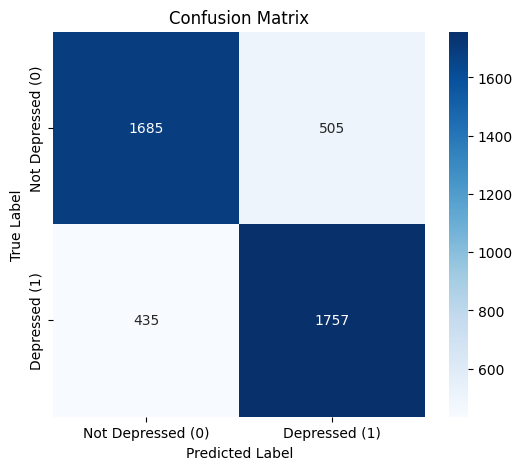

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# --- Final Performance Evaluation ---

# 1. Get model predictions on the test set
# .predict() gives probabilities, so we convert them to 0 or 1
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# 2. Calculate and print overall metrics
print("--- Overall Test Metrics ---")
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob) # Use probabilities for ROC-AUC

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

# 3. Print the detailed Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Depressed (0)', 'Depressed (1)']))

# 4. Display the Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Depressed (0)', 'Depressed (1)'],
            yticklabels=['Not Depressed (0)', 'Depressed (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [9]:
import os

# --- Time Complexity ---
print("--- Time Complexity ---")
# The 'training_time' variable was just updated by the last training run.
print(f"Total Training Time: {training_time:.2f} seconds (approx. {training_time/60:.1f} minutes)")

# Measure inference time for the final model
inference_start_time = time.time()
model.predict(X_test, batch_size=batch_size)
inference_end_time = time.time()
total_inference_time = inference_end_time - inference_start_time
avg_inference_time_ms = (total_inference_time / len(X_test)) * 1000

print(f"Total Inference Time for {len(X_test)} samples: {total_inference_time:.4f} seconds")
print(f"Average Inference Time per Sample: {avg_inference_time_ms:.4f} milliseconds")

# --- Space Complexity ---
print("\n--- Space Complexity ---")
# Save the final, best model to a file
model_filename = 'depression_detection_lstm_best.keras'
model.save(model_filename)

# Get the size of the saved model file
model_size_bytes = os.path.getsize(model_filename)
model_size_mb = model_size_bytes / (1024 * 1024)

print(f"Total Model Parameters: {model.count_params():,}")
print(f"Model Size on Disk: {model_size_mb:.2f} MB")

--- Time Complexity ---
Total Training Time: 3714.46 seconds (approx. 61.9 minutes)
137/137 ━━━━━━━━━━━━━━━━━━━━ 17s 127ms/step
Total Inference Time for 4382 samples: 17.6497 seconds
Average Inference Time per Sample: 4.0278 milliseconds

--- Space Complexity ---
Total Model Parameters: 17,192,805
Model Size on Disk: 66.73 MB


In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 192, 300)       │    17,048,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │       140,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,482,217 (66.69 MB)

 Trainable params: 144,705 (565.25 KB)

 Non-trainable params: 17,048,100 (65.03 MB)

 Optimizer params: 289,412 (1.10 MB)

In [11]:
import pickle

# Save the Keras Tokenizer to a file
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Tokenizer has been saved to 'tokenizer.pickle'")

Tokenizer has been saved to 'tokenizer.pickle'


In [12]:
# Run this in a new cell to save your trained model
model.save('bigru_fasttext_model.keras')

print("Model successfully saved!")

Model successfully saved!
